In [14]:
import sys
sys.path.append("../src/")

import pandas as pd
import numpy as np
from torchvision import transforms
from textDataset import *

from models import BoWClassifier, Tfid

import torch
import torch.nn as nn
import torch.optim as optim

from trainner import TrainnerNLP

from gensim.models import word2vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import time
from scipy.spatial.distance import cdist

import multiprocessing

%matplotlib inline  

In [15]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


In [16]:
path2data = '../data/sentiment_analysis/'

text = {
        'train': TextDataset(path2data + 'train/', extension='.tsv', sep='\t', is_train = True),
}    

In [17]:
#col = 'headline_text'
#col = 'comment_text'
col = 'Phrase'
text['train'].process_data(col = col, remove_stopw = True, remove_tags=True)

In [18]:
text['train'].data.head()

,PhraseId,SentenceId,Phrase,Sentiment,subject,Phrase_data
0,1,1,A series of escapades demonstrating the adage ...,1,train,"{occasionally, also, none, amounts, adage, amu..."
1,2,1,A series of escapades demonstrating the adage ...,2,train,"{adage, goose, good, demonstrating, series, es..."
2,3,1,A series,2,train,{series}
3,4,1,A,2,train,{}
4,5,1,series,2,train,{series}


In [19]:
sentences = { 'train': text['train'].data[col + '_data'].values}

In [20]:
X = sentences['train']
#classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
classes = ['Sentiment']
y = np.concatenate([np.array(i) for i in text['train'].data[classes].values])

In [21]:
class_count=pd.value_counts(y, sort=False)

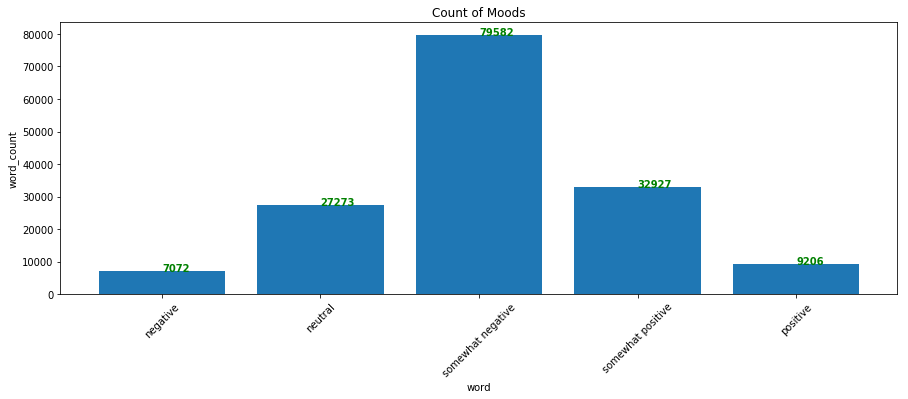

In [22]:
Index = np.arange(1,len(class_count)+1)
classes = ['negative','neutral','somewhat negative','somewhat positive','positive']
plt.figure(figsize=(15,5))
plt.bar(Index,class_count,color = 'blue')
plt.xticks(Index,classes,rotation=45)
plt.ylabel('word_count')
plt.xlabel('word')
plt.title('Count of Moods')
plt.bar(Index, class_count)
for a,b in zip(Index, class_count):
    plt.text(a, b, str(b) ,color='green', fontweight='bold')

### Split data in training and validation set

In [23]:
test_size = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

In [24]:
# Set values for various parameters
num_features = 500    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = cpu_count  # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words


# train model
model = word2vec.Word2Vec(X_train, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)
model.init_sims(replace=True)

In [25]:
def makeFeatureVec(words, model, num_features):
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype="float32")
    #
    nwords = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec, model[word])
    # Divide the result by the number of words to get the average
    if nwords == 0:
        nwords = 1
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [26]:
def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews), num_features), dtype="float32")
    counter = 0
    # Loop through the reviews
    for review in reviews:
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [27]:
f_matrix_train = getAvgFeatureVecs(X_train, model, num_features)
f_matrix_valid = getAvgFeatureVecs(X_valid, model, num_features)

/home/renatolr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


### Determining number of clusters - Elbow Rule
###### When K increases, the centroids are closer to the clusters centroids.

In [ ]:
# k means determine k
distortions = []
max_nb_cluster = 20
for k in range(1,max_nb_cluster):
    kmeanModel = KMeans(n_clusters=k).fit(f_matrix_train)
    kmeanModel.fit(f_matrix_train)
    distortions.append(sum(np.min(cdist(f_matrix_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / f_matrix_train.shape[0])

In [ ]:
# Plot the elbow
plt.plot(range(1,max_nb_cluster), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [52]:
start = time.time() # Start time
num_clusters = 5
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  5.6567065715789795 seconds.


In [54]:
# For the first 5 clusters
for cluster in range(0,num_clusters):
    
    print ("\nCluster %d" % cluster)
    words = []
    for key, value in word_centroid_map.items():
        if( value == cluster ):
            words.append(key)
    print (words)


Cluster 0
['characters', 'life', 'love', 'new', 'work', 'us', 'two', 'action', 'world', 'drama', 'sense', 'without', 'humor', 'real', 'hollywood', 'man', 'human', 'old', 'moments', 'family', 'acting', 'american', 'far', 'almost', 'young', 'emotional', 'entertaining', 'thriller', 'cinema', 'dialogue', 'picture', 'music', 'tale', 'war', 'women', 'history', 'special', 'compelling', 'visual', 'style', 'star', 'point', 'show', 'entertainment', 'direction', 'together', 'piece', 'true', 'experience', 'lives', 'dull', 'children', 'fascinating', 'gives', 'feature', 'set', 'whose', 'narrative', 'part', 'men', 'culture', 'title', 'modern', 'effects', 'study', 'engaging', 'power', 'woman', 'spirit', 'social', 'filmmaking', 'french', 'portrait', 'romance', 'wit', 'version', 'exercise', 'camera', 'black', 'recent', 'debut', 'offers', 'sort', 'truly', 'rich', 'opera', 'solid', 'tragedy', 'personal', 'fine', 'beyond', 'message', 'lack', 'eyes', 'play', 'perfect', 'rare', 'images', 'ride', 'imaginatio

In [14]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.wv.index2word, idx ))

## Words visualization using PCA

/home/renatolr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


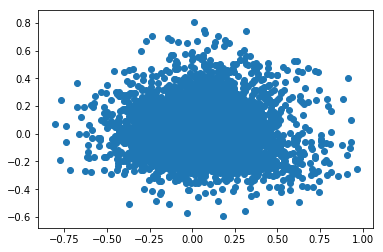

In [16]:
X_voc = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X_voc)
plt.scatter(result[:, 0], result[:, 1])
plt.show()

## Words visualization using t-SNE

In [64]:
def tsne_plot(model):
    
    "Creates and TSNE model and plots it"
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/home/renatolr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


KeyboardInterrupt: 

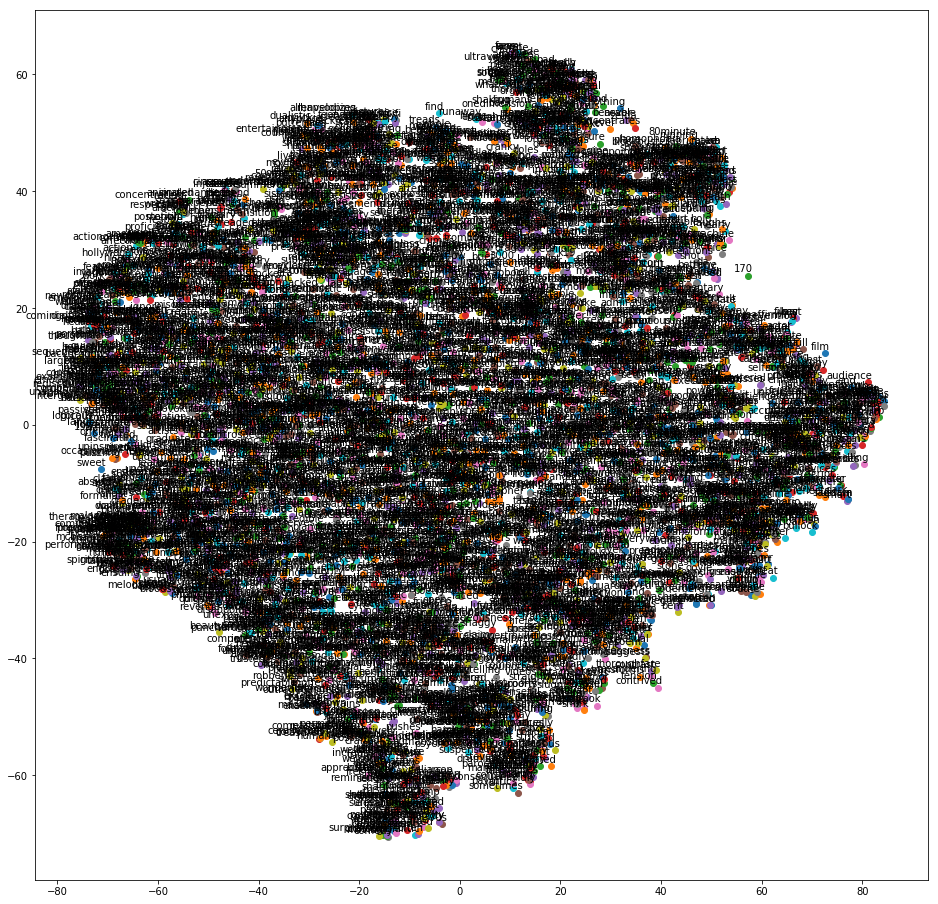

In [65]:
tsne_plot(model)